In [2]:
%config InlineBackend.figure_format = 'svg'
from datetime import datetime
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from skylark import skylark_root, MB, GB
from skylark.chunk import ChunkState

base_dir = skylark_root / "data" / "experiments" / "benchmark_num_connections"
fig_dir = base_dir / "figures" / "benchmark_num_connections" / datetime.now().strftime("%Y%m%d_%H%M%S")
fig_dir.mkdir(exist_ok=True, parents=True)

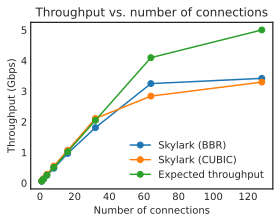

In [4]:
def read_dir(dir):
    data_recs = []
    for file in dir.glob("*/*.log"):
        try:
            num_connections = int(file.name.split(".")[0])
        except ValueError:
            continue
        with file.open("r") as f:
            data = f.read()
        # search for first json line starting from the end
        json_start = data.rfind("{")
        json_end = data.rfind("}")
        json_line = data[json_start : json_end + 1]
        if json_line:
            json_data = json.loads(json_line)
            json_data["num_connections"] = num_connections
            data_recs.append(json_data)
    return pd.DataFrame(data_recs)


df_bbr = read_dir(base_dir / "logs_bbr")
df_bbr["label"] = "Skylark (BBR)"

df_cubic = read_dir(base_dir / "logs_cubic")
df_cubic["label"] = "Skylark (CUBIC)"

df = pd.concat([df_bbr, df_cubic]).sort_values(by="num_connections")
min_nc = df.num_connections.min()
min_tput = df[df.num_connections == min_nc].throughput_gbits.mean()
for idx, nc in enumerate(sorted(df.num_connections.unique())):
    row = {"label": "Expected throughput", "num_connections": nc, "throughput_gbits": min(5, min_tput * nc / min_nc)}
    df = df.append(row, ignore_index=True)

with plt.style.context("seaborn-white", {"font.size": 10}):
    fig, ax = plt.subplots(figsize=(4, 3))
    for label in df.label.unique():
        df_label = df[df.label == label]
        ax.plot(df_label.num_connections, df_label.throughput_gbits, marker="o", label=label)
    ax.set_xlabel("Number of connections")
    ax.set_ylabel("Throughput (Gbps)")
    ax.legend(loc="best")
    fig.tight_layout()

    # log scale
    # ax.set_xscale("log")
    # ax.set_yscale("log")

    ax.set_title("Throughput vs. number of connections")
    fig.savefig(fig_dir / "throughput_vs_num_connections.png", dpi=300, bbox_inches="tight")
    fig.savefig(fig_dir / "throughput_vs_num_connections.pdf", dpi=300, bbox_inches="tight")

,total_runtime_s,throughput_gbits,monitor_status,success,num_gateways,label
0,20.062833,3.189978,completed,1.0,1,Skylark
1,19.555170,6.545584,completed,1.0,2,Skylark
2,25.503606,10.037796,completed,1.0,4,Skylark
3,22.812090,22.444239,completed,1.0,8,Skylark
4,27.705475,36.960204,completed,1.0,16,Skylark
5,28.178145,40.882748,completed,1.0,18,Skylark
6,NaN,3.189978,NaN,NaN,1,Expected throughput
7,NaN,6.379956,NaN,NaN,2,Expected throughput
8,NaN,12.759913,NaN,NaN,4,Expected throughput
9,NaN,25.519826,NaN,NaN,8,Expected throughput


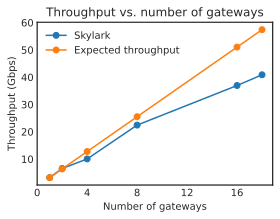

In [23]:
base_dir = skylark_root / "data" / "experiments" / "benchmark_num_gateways"
experiment_ids = [
    "aws:ap-northeast-1-aws:eu-central-1-pockmark-lovely-dreaming-tomtom",
    "aws:ap-northeast-1-aws:eu-central-1-ire-commandments-amazing-wimbledon",
    "aws:ap-northeast-1-aws:eu-central-1-tidewater-saltine-sup-luna",
    "aws:ap-northeast-1-aws:eu-central-1-winnow-memorials-tonally-substantive",
    "aws:ap-northeast-1-aws:eu-central-1-vernon-smooch-tommy-iso",
]


def read_dir_ng(dir, experiment_ids):
    data_recs = []
    for experiment in experiment_ids:
        for file in dir.glob(f"{experiment}/*.log"):
            try:
                num_connections = int(file.name.split(".")[0])
            except ValueError:
                continue
            with file.open("r") as f:
                data = f.read()
            # search for first json line starting from the end
            json_start = data.rfind("{")
            json_end = data.rfind("}")
            json_line = data[json_start : json_end + 1]
            if json_line:
                json_data = json.loads(json_line)
                json_data["num_gateways"] = int(num_connections)
                data_recs.append(json_data)
    return pd.DataFrame(data_recs)


df = read_dir_ng(base_dir / "logs", experiment_ids).sort_values(by="num_gateways")
df["label"] = "Skylark"
min_ng = df.num_gateways.min()
min_tput = df[df.num_gateways == min_ng].throughput_gbits.mean()
for idx, ng in enumerate(sorted(df.num_gateways.unique())):
    row = {"label": "Expected throughput", "num_gateways": int(ng), "throughput_gbits": min_tput * ng / min_ng}
    df = df.append(row, ignore_index=True)

with plt.style.context("seaborn-white", {"font.size": 10}):
    fig, ax = plt.subplots(figsize=(4, 3))
    for label in df.label.unique():
        df_label = df[df.label == label]
        ax.plot(df_label.num_gateways, df_label.throughput_gbits, marker="o", label=label)
    ax.set_xlabel("Number of gateways")
    ax.set_ylabel("Throughput (Gbps)")
    ax.set_xticks(np.arange(0, df.num_gateways.max() + 1, 4))
    ax.legend(loc="best")
    fig.tight_layout()

    ax.set_title("Throughput vs. number of gateways")
    fig.savefig(fig_dir / "throughput_vs_num_gateways.png", dpi=300, bbox_inches="tight")
    fig.savefig(fig_dir / "throughput_vs_num_gateways.pdf", dpi=300, bbox_inches="tight")
df